In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [136]:
seed = 2

In [164]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
injury = pd.read_excel("../spring21_data/season_ending_and_indefinitely.xlsx")
injury_fa = df.merge(right=injury, how='inner', left_on=['clean_season', 'Player'], right_on=['clean_season', 'Player']).rename(columns={'Unnamed: 0': 'index'})
df = df[~df['Unnamed: 0'].isin(injury_fa['index'])]
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.85,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.25,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.001,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 14/14 [00:00<00:00, 304.07it/s]


In [8]:
X = pd.read_excel('X.xlsx')
y = pd.read_excel('y.xlsx')
X_test = pd.read_excel('X_test.xlsx')
y_test = pd.read_excel('y_test.xlsx')

In [13]:
X.set_index('Unnamed: 0', inplace=True)
X_test.set_index('Unnamed: 0', inplace=True)
y.set_index('Unnamed: 0', inplace=True)
y_test.set_index('Unnamed: 0', inplace=True)

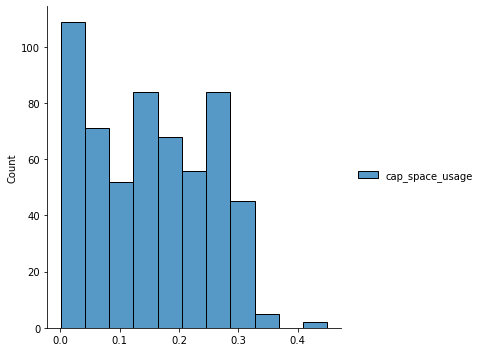

In [165]:
sns.displot(y)

In [15]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=40)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(20)['features'])

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [17]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

### Without train-validation-test split
**Since we have bootstrap in random forest, as it is based on the idea of bagging**, we can use oob_score as score for validation set and **save the trouble of using train-validation-test split.**

**Below is the experimentation**

In [19]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', 
                                  max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                  bootstrap=True, oob_score=True, n_jobs=-1, random_state=77, verbose=0, warm_start=False, 
                                  ccp_alpha=0.0, max_samples=None)
rf.fit(X[features], y)
evaluate(rf.predict(X[features]), y)

r^2:  0.9788284042690432
mse:  0.00021968725802528472
variance_score:  0.9788983996372435
mse-log:  0.00016548020850047163


In [20]:
rf.oob_score_

0.8465628429881118

In [22]:
evaluate(rf.predict(X_test[features]), y_test)

r^2:  0.8567334077002254
mse:  0.0011331202555609854
variance_score:  0.8624520623355356
mse-log:  0.0009149380027101134


In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 500, num = 25)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [i for i in range(1, 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [i for i in range(1, 10)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(warm_start=True, bootstrap=True, oob_score=True) # use warm_start to speed up
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 400, cv = 5, verbose=2, random_state=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(oob_score=True,
                                                   warm_start=True),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 71, 91, 112,
                                                      132, 152, 173, 193, 214,
                                                      234, 255, 275, 295, 316,
                                                      336, 357, 377, 397, 418,
                                                      438, 459, 479, 500,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_spli

In [28]:
rf_random.best_params_

{'n_estimators': 406,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 234}

In [39]:
best = RandomForestRegressor(n_estimators=806,
                                  max_depth=234, min_samples_split=4, min_samples_leaf=2, 
                                  max_features='log2', 
                                  bootstrap=True, oob_score=True, n_jobs=-1, random_state = 8)
best.fit(X[features], y)
evaluate(best.predict(X[features]), y)

r^2:  0.9642277828742626
mse:  0.00037119074035347625
variance_score:  0.9642932026183674
mse-log:  0.0002805340008336692


In [40]:
best.oob_score_

0.8489203443885647

In [41]:
evaluate(best.predict(X_test[features]), y_test)

r^2:  0.8751004269536062
mse:  0.000987852323824766
variance_score:  0.8802649031192502
mse-log:  0.0008038571687809607


In [43]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [44]:
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=best.predict(X_test[features]))], axis=1)

In [45]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
377,2019,Dragan Bender,18.0,4.282609,17.956522,0.5,0.797767,1778,0.015383,0.029882
105,2016,Wayne Ellington,21.3,7.381579,21.250000,0.8,-1.193968,3266,0.063733,0.043428
60,2016,Dewayne Dedmon,12.2,3.051724,12.155172,2.4,1.009431,1434,0.030783,0.031327
0,2016,Kevin Durant,35.8,19.180556,35.805556,14.5,12.406201,6806,0.281913,0.326480
285,2019,Kawhi Leonard,34.0,18.816667,34.000000,9.5,8.845318,6150,0.300000,0.305029
283,2018,Avery Bradley,31.2,14.250000,31.700000,-0.2,0.433693,2918,0.117798,0.123951
179,2017,Michael Beasley,16.7,7.250000,16.696429,1.8,0.622438,1991,0.014848,0.056589
126,2017,Andre Iguodala,26.3,5.460526,26.289474,6.9,5.790783,5120,0.149504,0.123089
327,2019,Tyus Jones,22.9,6.558824,22.941176,3.0,3.210259,3329,0.077039,0.071677
86,2016,Terrence Jones,20.9,7.340000,20.880000,1.5,-0.660942,2167,0.011163,0.052050
